# Carbon MD simulation

This notebook will install and compile lammps, then run a small 64-atom simulated melt-quench using a GAP potential

__License warning__ The GAP code is free to use for non-commerical purposes only. Please refer to [here](https://libatoms.github.io/GAP/installation.html)
for more details



Joe D. Morrow 

In [1]:
%%capture
# install some python packages if not already done
# !conda create -n how-to-validate python=3.8
# !pip install -r requirements.txt 

In [2]:
%%capture
# compile lammps with QUIP support
!wget "https://github.com/lammps/lammps/archive/stable.zip"
print("lammps downloaded")
!unzip -q stable.zip
!rm stable.zip
!mv lammps-stable lammps
print("compiling...")
!cd lammps && mkdir -p build && cd build && cmake ../cmake \
    -D PKG_ML-QUIP=yes -D DOWNLOAD_QUIP=yes -D USE_INTERNAL_LINALG=yes && make -j4 &> lammps/make.log

In [4]:
rundir = 'lammps_runs/run_nvt'   # directory for the output files
data_file = 'structures/random_1.data'  # random initial structure - density is determined by this
restart_from = 'data'  # change to "continuation" to restart from previous run
random_seed = 2023        # random seed for lammps
melt_timesteps = 1000     # Timesteps in fs for melting
cool_timesteps = 1000     # Timesteps in fs for quenching (more = slower quench)
melt_temperature = 9000   # in Kelvin
final_temperature = 300   # in Kelvin

# input file for LAMMPS
lammps_nvt_input = f'''
log {rundir}/log_nvt_C.dat append

units metal
atom_style atomic

if "{restart_from} == data" then "read_data {data_file}"
if "{restart_from} == data" then "reset_timestep 0"
if "{restart_from} == continuation" then "read_restart {rundir}/restart_nvt_C.*"

mass 1 12.011  # mass of carbon
pair_style quip
# carbon GAP potential from https://doi.org/10.1103/PhysRevB.95.094203
pair_coeff * * potentials/carbon.xml \"\" 6

neighbor 2.0 bin 
neigh_modify every 1 delay 0 check yes 

variable nAtoms equal atoms
group carbon type 1
timestep 0.001 
fix removeMomentum all momentum 1 linear 1 1 1 

compute T all temp 
variable P equal press
variable v equal vol
compute MSD all msd
fix TempAve all ave/time 100 1 100 c_T 
fix PressAve all ave/time 100 1 100 v_P 
fix vAve all ave/time 100 1 100 v_v

compute pe_at all pe/atom
compute PE all pe pair 
variable PE_Atom equal c_PE/v_nAtoms
fix PEAve_Atom all ave/time 100 1 100 v_PE_Atom

# Set up output files
thermo_style custom step cpu temp f_TempAve press f_PressAve f_PEAve_Atom vol f_vAve c_MSD[4] 
thermo_modify flush yes
thermo 100
dump traj all cfg 100 {rundir}/NVT/dump_nvt_C.*.cfg mass type xs ys zs id c_pe_at
dump_modify traj sort id element C pad 8
restart 100 {rundir}/restart_nvt_C.*

# Set up NVT run
variable Nrun1 equal {melt_timesteps}
variable Nrun2 equal (${{Nrun1}}+{cool_timesteps})
if "{melt_timesteps} > 0 && $(step) == 0" then "velocity all create {melt_temperature} {random_seed}"

# (1) melting 
run 0
fix integrate all nvt temp {melt_temperature} {melt_temperature} 0.1
if "$(step) < ${{Nrun1}}" then "run ${{Nrun1}} upto"
unfix integrate

# (2) quenching
fix integrate all nvt temp {melt_temperature} {final_temperature} 0.1
if "$(step) < ${{Nrun2}}" then "run ${{Nrun2}} upto start ${{Nrun1}} stop ${{Nrun2}}"
unfix integrate

write_data {rundir}/out_data_quench_C
'''

with open("lammps_runs/nvt.in", "w") as f:
    f.write(lammps_nvt_input)

# Run lammps
Now we run an NVT simulation using the input file above  
and the carbon GAP potential from [Phys. Rev. B __95__, 094203](https://doi.org/10.1103/PhysRevB.95.094203)

This should take about 15 minutes to run on a single core

If it's not working, there's an example trajectory at `lammps_runs/run_nvt_test.tar.gz`  
run `tar -xzf lammps_runs/run_nvt_test.tar.gz` to decompress

In [2]:
!mkdir -p ./lammps_runs/${rundir}/NVT
!export OMP_NUM_THREADS=1 && mpirun -np 1 lammps/build/lmp -in lammps_runs/nvt.in

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
LAMMPS (23 Jun 2022 - Update 2)
  using 1 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (0 0 0) to (8.1096027 8.1096027 8.1096027)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  64 atoms
  read_data CPU = 0.012 seconds
64 atoms in group carbon
Neighbor list info ...
  update every 1 steps, delay 0 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 5.7
  ghost atom cutoff = 5.7
  binsize = 2.85, bins = 3 3 3
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair quip, perpetual
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocatio

# Check simulation results

In [7]:
from share.utilities import read_lammps_log
import numpy as np
import matplotlib.pyplot as plt

In [31]:
!tar -xzf lammps_runs/run_nvt_test.tar.gz

In [32]:
rundir = 'lammps_runs/run_nvt_test'
thermo = read_lammps_log(f'{rundir}/log_nvt_C.dat')
thermo.head()  # a Pandas dataframe

,Step,CPU,Temp,f_TempAve,Press,f_PressAve,f_PEAve_Atom,Volume,f_vAve,c_MSD[4]
0,0.0,0.000000,9000.0000,9000.0000,45037.514,45037.514,-154.74294,5120.0,5120.0,0.000000
2,100.0,43.179437,12289.9920,12289.9920,160892.050,160892.050,-155.47246,5120.0,5120.0,9.610055
3,200.0,86.381652,10436.4180,10436.4180,83149.081,83149.081,-155.58601,5120.0,5120.0,20.201032
4,300.0,130.148240,9040.9555,9040.9555,69820.276,69820.276,-155.66487,5120.0,5120.0,30.030614
5,400.0,172.137640,8724.6809,8724.6809,66619.214,66619.214,-155.74949,5120.0,5120.0,37.342991


[Text(0.5, 0, 'Timestep (fs)'), Text(0, 0.5, 'Temperature (K)')]

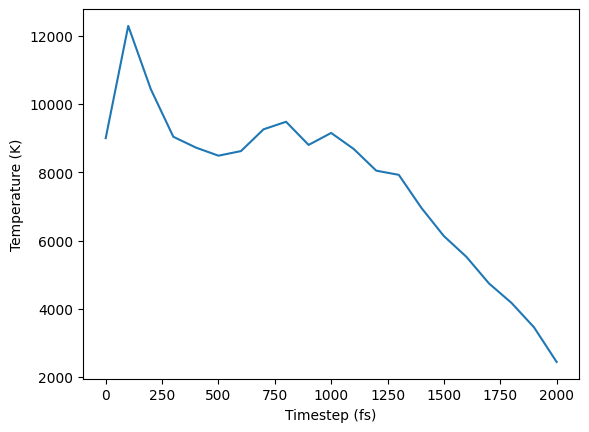

In [9]:
fig, axs = plt.subplots()

axs.plot(thermo['Step'], thermo['f_TempAve'])
axs.set(xlabel='Timestep (fs)', ylabel='Temperature (K)')

Visualisation using [Ovito](https://www.ovito.org/)
<img src="images/carbon_liquid.png" style="width:400px;height:400px;"> 
<img src="images/carbon_quench.png" style="width:400px;height:400px;"> 

# Structure analysis

In [33]:
from quippy.descriptors import Descriptor
import os
from os.path import join
from ase.io import read, write
plt.style.use('./share/plot.mplstyle')

In [34]:
# read the structures
traj_dir = f'./{rundir}/NVT/'
atoms = [read(join(traj_dir, i)) for i in os.listdir(traj_dir)]
for i in range(len(atoms)):
    atoms[i].set_atomic_numbers(6*np.ones(len(atoms[i])))
atoms[1]

Atoms(symbols='C512', pbc=True, cell=[17.23547752, 17.23547752, 17.23547752])

## RDF analysis

In [35]:
from ase.geometry.analysis import Analysis

In [36]:
geo_analysis_start = Analysis(atoms[5])
geo_analysis_end= Analysis(atoms[-1])

rdf_start = geo_analysis_start.get_rdf(rmax=4, nbins=50, return_dists=True)[0]
rdf_end = geo_analysis_end.get_rdf(rmax=4, nbins=50, return_dists=True)[0]

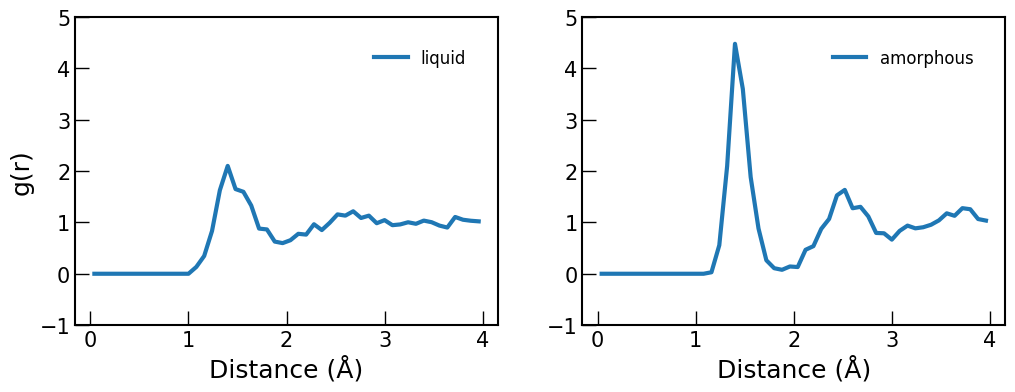

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(rdf_start[1], rdf_start[0], label='liquid')
axs[1].plot(rdf_end[1], rdf_end[0], label='amorphous')

axs[0].set(xlabel='Distance (Å)', ylabel='g(r)', ylim=(-1, 5))
axs[1].set(xlabel='Distance (Å)', ylim=(-1, 5))

axs[0].legend(frameon=False, loc='upper right')
axs[1].legend(frameon=False, loc='upper right')